In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from sklearn.cluster import KMeans

## LOG

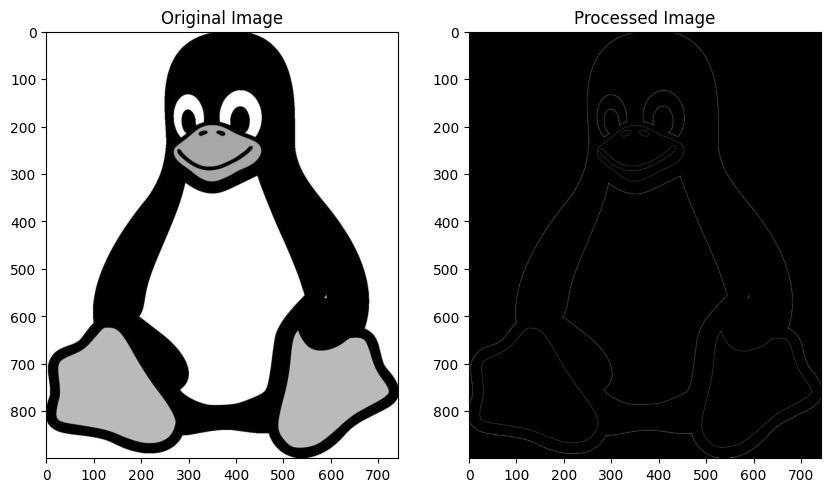

In [2]:
img = cv2.imread('penguin.jpg', cv2.IMREAD_GRAYSCALE)

blur1 = cv2.GaussianBlur(img, (1, 1), 0)
blur2 = cv2.GaussianBlur(img, (3, 3), 0)

dog_img = cv2.subtract(blur1, blur2)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(dog_img, cmap='gray')
ax2.set_title('Processed Image')
plt.show()

## SIFT

### Part1

In [57]:
def apply_sift(img_pathes, **sift_kwargs):

    for img_path in img_pathes:
        img = cv2.imread(img_path)
        img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        sift = cv2.SIFT_create(**sift_kwargs)
        keypoints, descriptors = sift.detectAndCompute(img_grayscale, None)
        print(f'Num keypoints for {img_path}: {len(keypoints)}')

        img_keypoints = cv2.drawKeypoints(img_grayscale, keypoints, img)
        plt.figure(figsize=(8, 8))
        plt.imshow(img_keypoints)
        plt.title(f'{img_path} keypoints')

Num keypoints for img1.jpg: 1613
Num keypoints for img2.jpg: 899


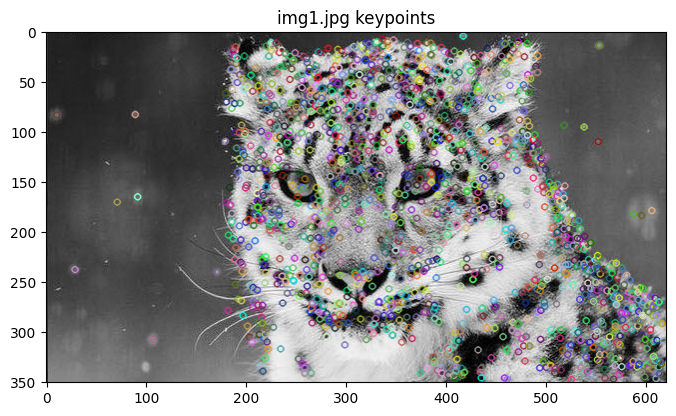

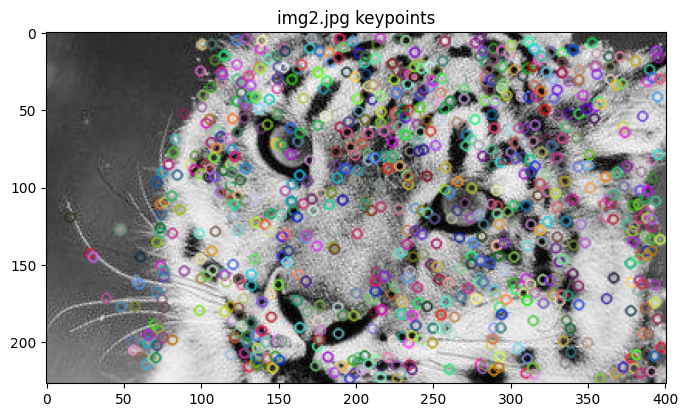

In [58]:
img_pathes = ['img1.jpg', 'img2.jpg']
apply_sift(img_pathes)

Num keypoints for img1.jpg: 2
Num keypoints for img2.jpg: 1


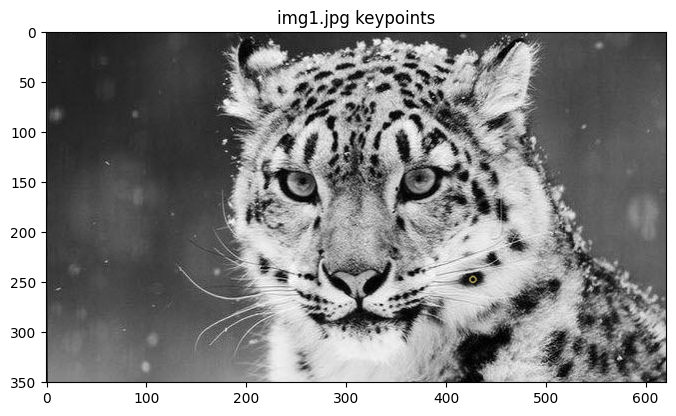

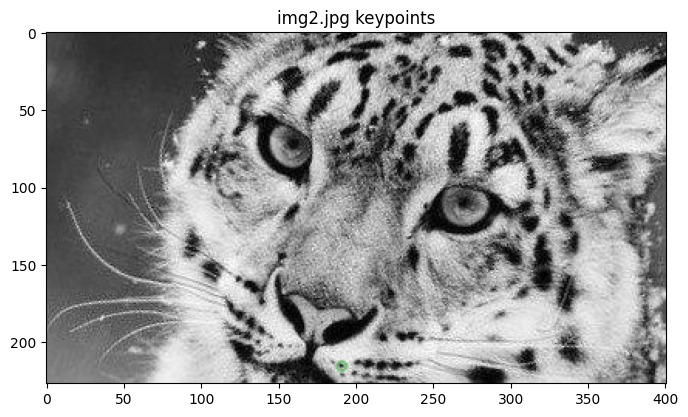

In [59]:
# Changing Parameters: nfeatures: 0 -> 1
sift_kwargs = {'nfeatures': 1}
apply_sift(img_pathes, **sift_kwargs)

As we increase this parameters, less keypoints are returned by the algorithm.

Num keypoints for img1.jpg: 2150
Num keypoints for img2.jpg: 1077


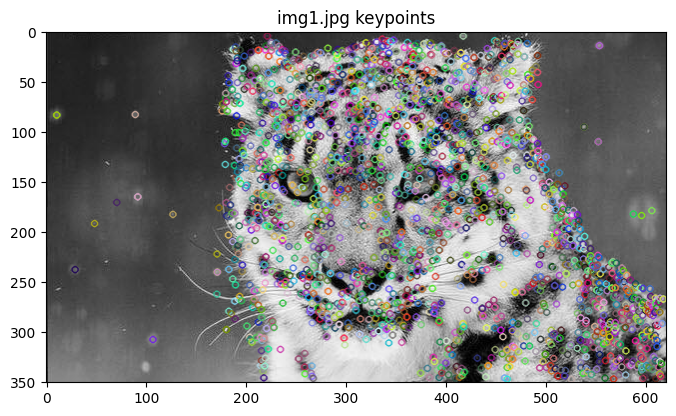

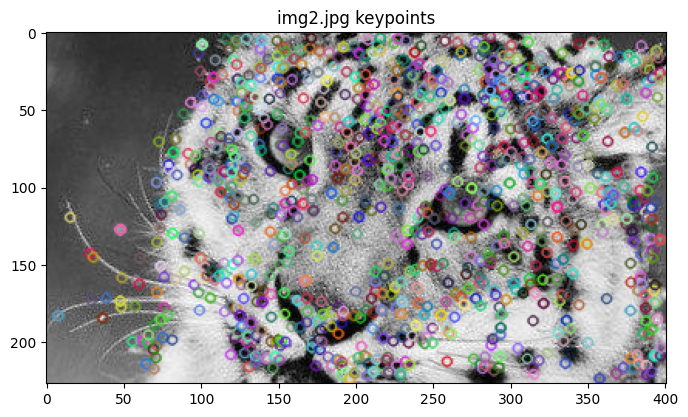

In [60]:
# Changing Parameters: nOctaveLayers: 3 -> 5
sift_kwargs = {'nOctaveLayers': 5}
apply_sift(img_pathes, **sift_kwargs)

The larger this parameter, the more keypoints we get. This is quite intuitive since we are using more layers in each octave, we get more fine-grained details and more keypoints as a result.

Num keypoints for img1.jpg: 1048
Num keypoints for img2.jpg: 562


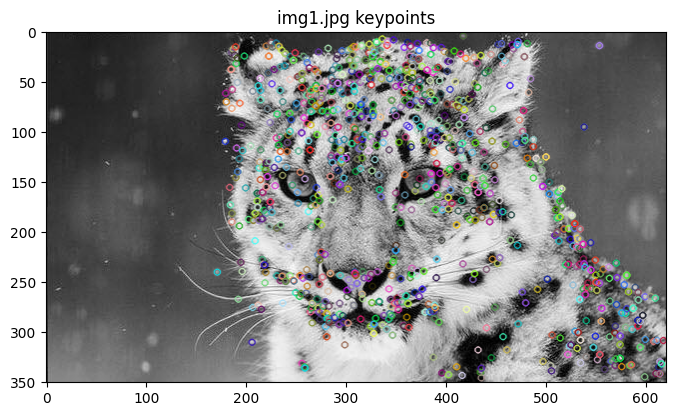

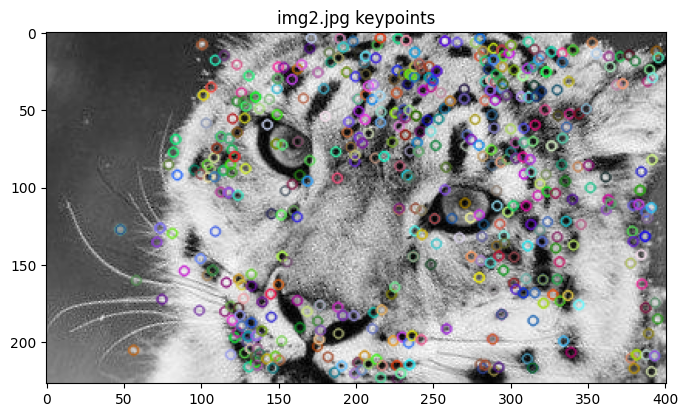

In [61]:
# Changing Parameters: contrastThreshold: 0.04 -> 0.1
sift_kwargs = {'contrastThreshold': 0.1}
apply_sift(img_pathes, **sift_kwargs)

The algorithm filters out the keypoints that have contrast lower than this threshold. Therefore, by increasing this parameter, we expect getting less keypoints as we remove more keypoints in the filtering process.

Num keypoints for img1.jpg: 593
Num keypoints for img2.jpg: 287


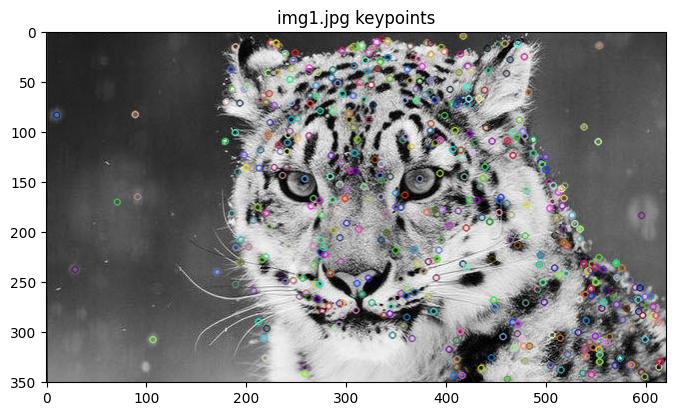

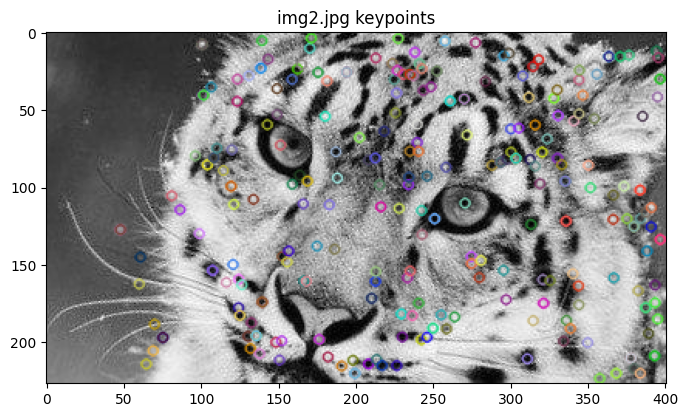

In [65]:
# Changing Parameters: edgeThreshold: 10 -> 2
sift_kwargs = {'edgeThreshold': 2}
apply_sift(img_pathes, **sift_kwargs)

The algorithms uses this to filter out edge-like filters. According to the paper, thelarger the edge threshild, the more features are retained.

Num keypoints for img1.jpg: 5834
Num keypoints for img2.jpg: 2943


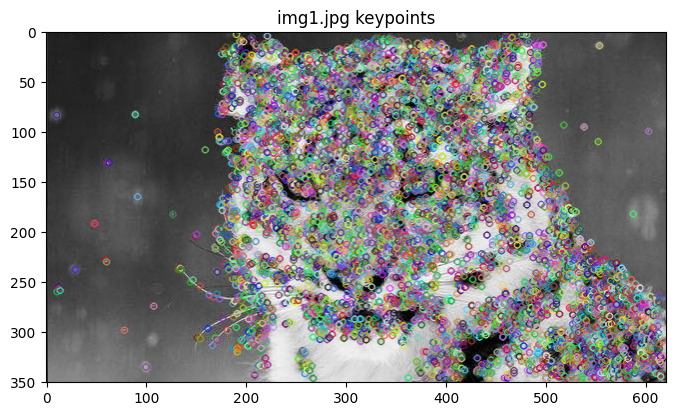

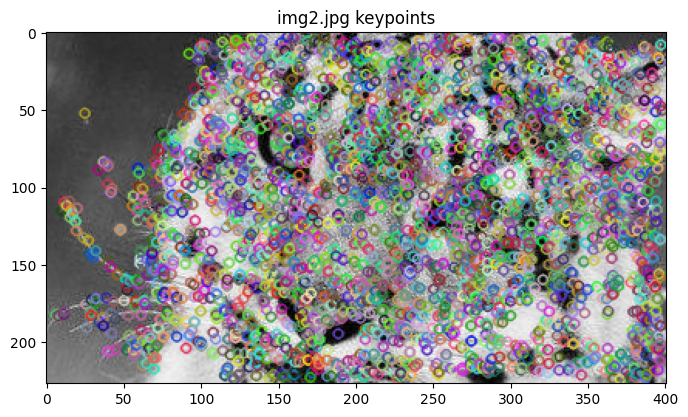

In [68]:
# Changing Parameters: sigma: 1.6 -> 1
sift_kwargs = {'sigma': 1}
apply_sift(img_pathes, **sift_kwargs)

Reducing this parameters results in more features. The higher the sigma parameter, the more image gets blurred. As a result, less keypoints are extracted.

Num keypoints for img1.jpg: 1516
Num keypoints for img2.jpg: 848


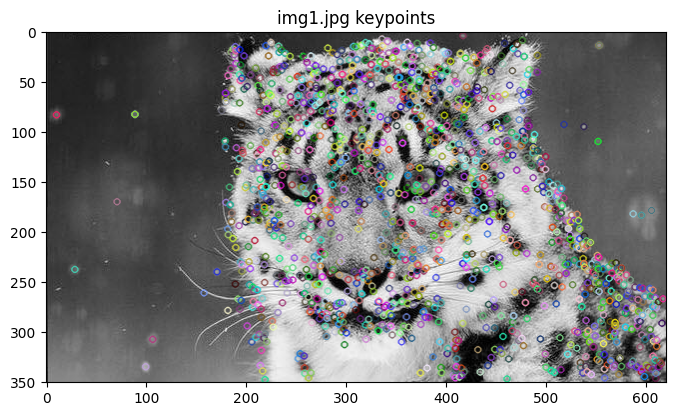

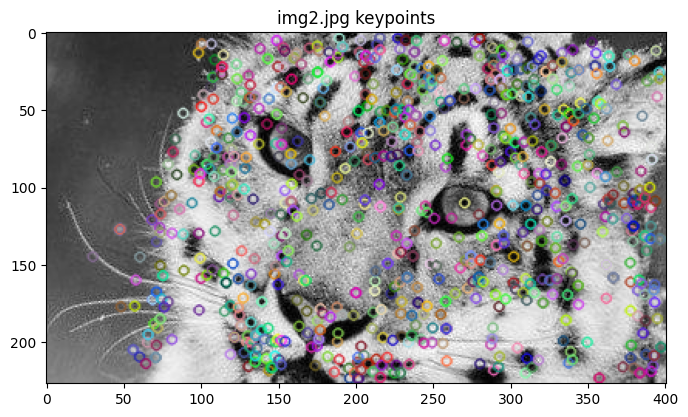

In [69]:
# Changing Parameters: enable precise upscale: False -> True
sift_kwargs = {'enable_precise_upscale': True}
apply_sift(img_pathes, **sift_kwargs)

### Part2

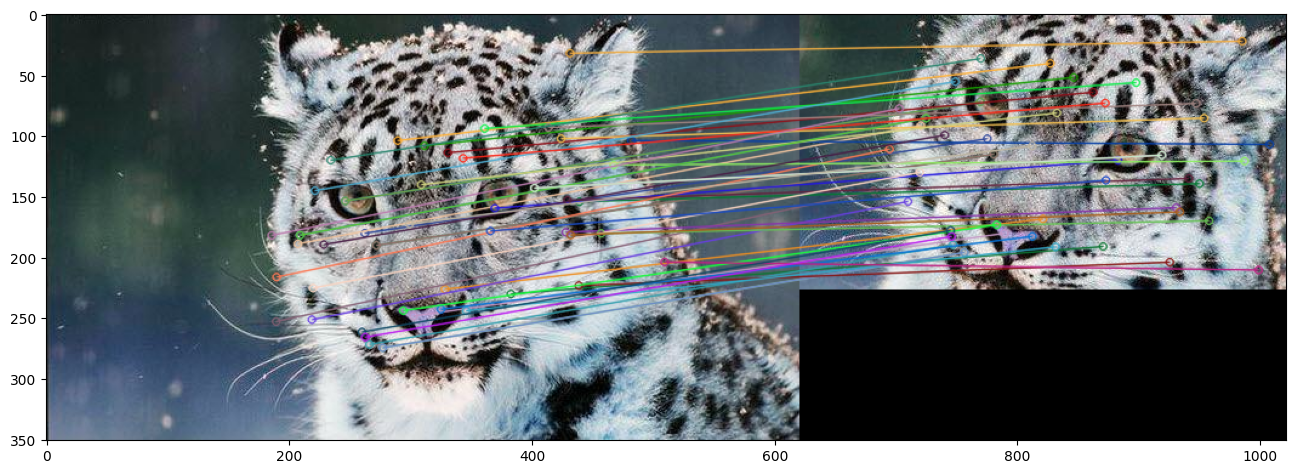

In [82]:
img1 = cv2.imread('img1.jpg')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('img2.jpg')
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Apply SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

# Feature Matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], img2, flags=2)
plt.figure(figsize=(16, 8))
plt.imshow(img_matches)
plt.show()

The keypoints are invariant with respect to rotation and resizing.

### Part3

Num keypoints for img1.jpg: 1613
Num keypoints for img3.jpg: 1223


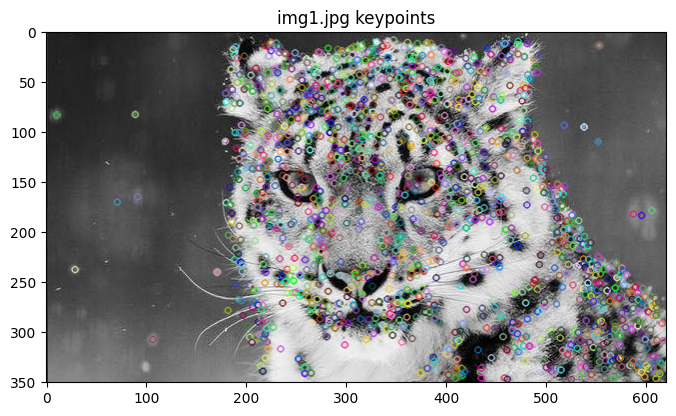

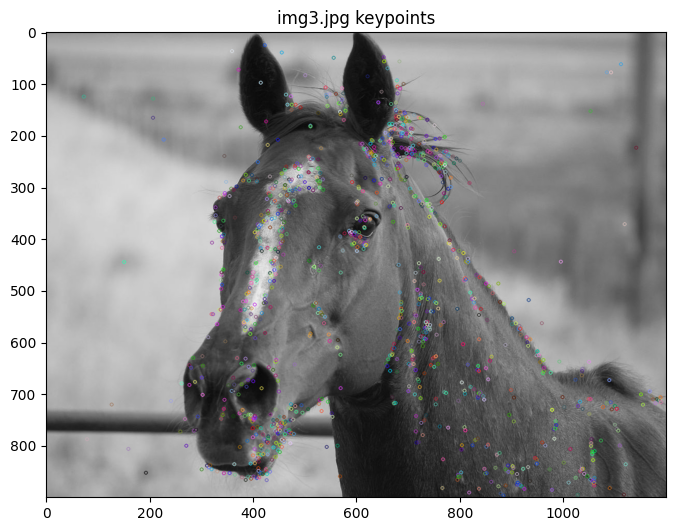

In [95]:
img1 = cv2.imread('img1.jpg')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img3 = cv2.imread('img3.jpg')
img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

# Apply SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints3, descriptors3 = sift.detectAndCompute(img3_gray, None)

apply_sift(['img1.jpg', 'img3.jpg'])

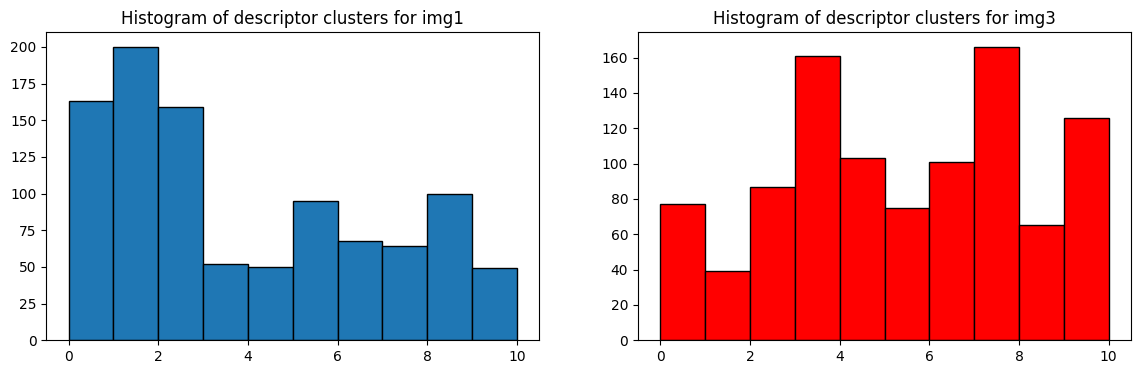

In [118]:
all_descriptors = [descriptors1[:1000, :], descriptors3[:1000, :]]
K = 10
kmeans = KMeans(n_clusters=K)
kmeans.fit(np.concatenate(all_descriptors, axis=0))

labels1 = kmeans.predict(all_descriptors[0])
hist1, bins1 = np.histogram(labels1, bins=range(K+1))

labels3 = kmeans.predict(all_descriptors[1])
hist3, bins3 = np.histogram(labels3, bins=range(K+1))

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title(f'Histogram of descriptor clusters for img1')
ax1.hist(labels1, bins1, edgecolor='black');

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title(f'Histogram of descriptor clusters for img3')
ax2.hist(labels3, bins3, color='red', edgecolor='black');

After applying Kmeans clustering, each centroid represents a visual feature in images. Therefore, we can view the histogram as a lower dimensional representation of the image. With this in mind, one can observe that two histograms above are very different since they represent different visual features.

### Part4

As mentioned earlier in Part3, histogram for each of the images forms a lower dimensional representation of that image. Therefore we can use this lower dimensional representations to train a classifier like logistic regression or SVM. In the test time, we first apply SIFT algorithm on target image, extracting descriptors out of it. Then we make histogram of that image with the cluster centroids found in the training time. The rest is pretty straightforward.